## Processing Ocean Color Imagery - Process Micasense Images

Pull in all images and process with micasense tools
    normalize and align and whatnot
    put these into functions and clean up
    also visualize along the way and look at distributions to think about whether or not they're legitimate
    write out
    
Pull in all images as modified and metadata with specific functions
    Visualize for issues and shadows and bright spots and locations
    correct for sky radiance
    visualize the distributions of both sky (clouds) and sea
    look at the variability of spectra both for specific pixels and across nearby images
    filter for orientation and location and issues

take the water leaving spectra and convert to chla as well as other future products and just intro general analysis of spectra
    produce a csv or .shp or images of ocean color products 
    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import multiprocessing
import glob, shutil, os

import cv2
import numpy as np
import matplotlib.pyplot as plt


import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import exiftool
import datetime

import subprocess
import math

from utils import *
from georeg import *

### Run the process

#### first sort the images into sea and sky

In [3]:
! ls data/20210728_newport_neuse_surveys/flight1

all_imgs  panel  rededge  sea  sky


In [4]:
all_img_dir = os.path.join('data', '20210728_newport_neuse_surveys', 'flight1', 'all_imgs')
sky_dst = os.path.join('data', '20210728_newport_neuse_surveys', 'flight1', 'sky')
sea_dst = os.path.join('data', '20210728_newport_neuse_surveys', 'flight1', 'sea')

In [7]:
if not os.path.exists(sky_dst):
    os.makedirs(sky_dst)

if not os.path.exists(sea_dst):
    os.makedirs(sea_dst)

down_image_count = 10
up_image_count = 2

#go through each image
i = 0
j = 0
count = 0
for file in sorted(glob.glob(all_img_dir+ "/*.tif")):
    if i < down_image_count*6:
        shutil.move(file, sea_dst)
        i += 1
        if i == down_image_count*6:
            j = 0
    elif j < up_image_count*6:
        shutil.move(file, sky_dst)
        j += 1
        if j == up_image_count*6:
            i = 0
    count += 1
print('moved', count, 'images')

moved 2916 images


### This is the typical full workflow

In [5]:
glob.glob(os.path.join('data', '20210728_newport_neuse_surveys', 'flight1', 'panel', 'IMG_0015*.tif'))

['data/20210728_newport_neuse_surveys/flight1/panel/IMG_0015_3.tif',
 'data/20210728_newport_neuse_surveys/flight1/panel/IMG_0015_1.tif',
 'data/20210728_newport_neuse_surveys/flight1/panel/IMG_0015_2.tif',
 'data/20210728_newport_neuse_surveys/flight1/panel/IMG_0015_5.tif',
 'data/20210728_newport_neuse_surveys/flight1/panel/IMG_0015_6.tif',
 'data/20210728_newport_neuse_surveys/flight1/panel/IMG_0015_4.tif']

In [6]:
! ls data/20210728_newport_neuse_surveys/flight1

all_imgs  panel  rededge  sea  sky


#### First process the Altum images

From https://support.micasense.com/hc/en-us/articles/360025336894-Using-Panels-and-or-DLS-in-Post-Processing

In the case of a clear, sunny day, we recommend using only the calibration panels. Light sensor data will not be as effective and so should generally not be used in this case.

Light sensor data is most effective in overcast, completely cloudy conditions. In this case, we would recommend using both light sensor and panel data for calibration.

In this case I'd like to use the DLS and the panel based on: https://micasense.github.io/imageprocessing/MicaSense%20Image%20Processing%20Tutorial%203.html


In [7]:
import numpy as np
import micasense.dls as dls

import os, glob
import micasense.capture as capture

image_names = glob.glob(os.path.join('data', '20210728_newport_neuse_surveys', 'flight1', 'panel', 'IMG_0015*.tif'))
cap = capture.Capture.from_filelist(image_names)

In [9]:
# Define DLS sensor orientation vector relative to dls pose frame
dls_orientation_vector = np.array([0,0,-1])
# compute sun orientation and sun-sensor angles
(
    sun_vector_ned,    # Solar vector in North-East-Down coordinates
    sensor_vector_ned, # DLS vector in North-East-Down coordinates
    sun_sensor_angle,  # Angle between DLS vector and sun vector
    solar_elevation,   # Elevation of the sun above the horizon
    solar_azimuth,     # Azimuth (heading) of the sun
) = dls.compute_sun_angle(cap.location(),
                      cap.dls_pose(),
                      cap.utc_time(),
                      dls_orientation_vector)

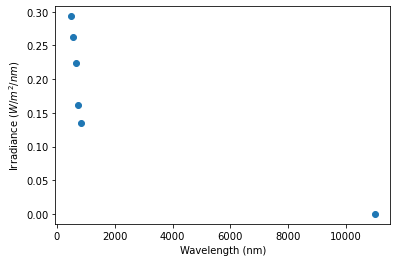

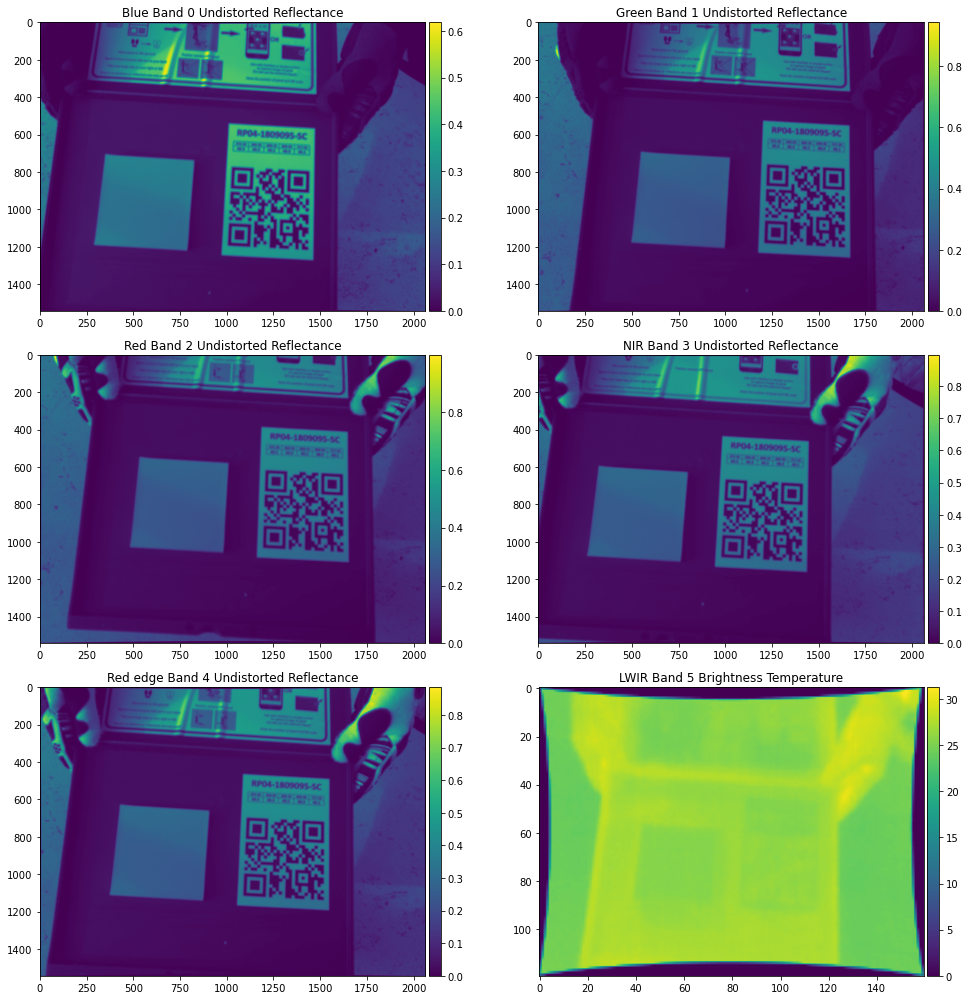

In [14]:
# Since the diffuser reflects more light at shallow angles than at steep angles,
# we compute a correction for this
fresnel_correction = dls.fresnel(sun_sensor_angle)

# Now we can correct the raw DLS readings and compute the irradiance on level ground
dls_irradiances = []
center_wavelengths = []
for img in cap.images:
    dir_dif_ratio = 6.0
    percent_diffuse = 1.0/dir_dif_ratio
    # measured Irradiance / fresnelCorrection
    sensor_irradiance = img.spectral_irradiance / fresnel_correction
    untilted_direct_irr = sensor_irradiance / (percent_diffuse + np.cos(sun_sensor_angle))
    # compute irradiance on the ground using the solar altitude angle
    dls_irr = untilted_direct_irr * (percent_diffuse + np.sin(solar_elevation))
    dls_irradiances.append(dls_irr)
    center_wavelengths.append(img.center_wavelength)

import matplotlib.pyplot as plt
plt.scatter(center_wavelengths,dls_irradiances)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance ($W/m^2/nm$)')
plt.show();

cap.plot_undistorted_reflectance(dls_irradiances)

In [28]:
cap.dls_irradiance() * np.array([0.521835  , 0.56514118, 0.59965098, 0.58979034, 0.59371461])

[0.26924354704584974,
 0.24339933961366375,
 0.20623750707045577,
 0.12262944766833851,
 0.14428277508779266,
 0]

In [32]:
dls_correction

array([0.521835  , 0.56514118, 0.59965098, 0.58979034, 0.59371461])

In [26]:
irr_from_panel,dls_irradiances

(array([0.14050071, 0.13755499, 0.12367052, 0.07232566, 0.08566279]),
 [0.2933200748659934,
  0.26222689782982234,
  0.2243749897226455,
  0.13465925195234787,
  0.16123473294179935,
  0.0])

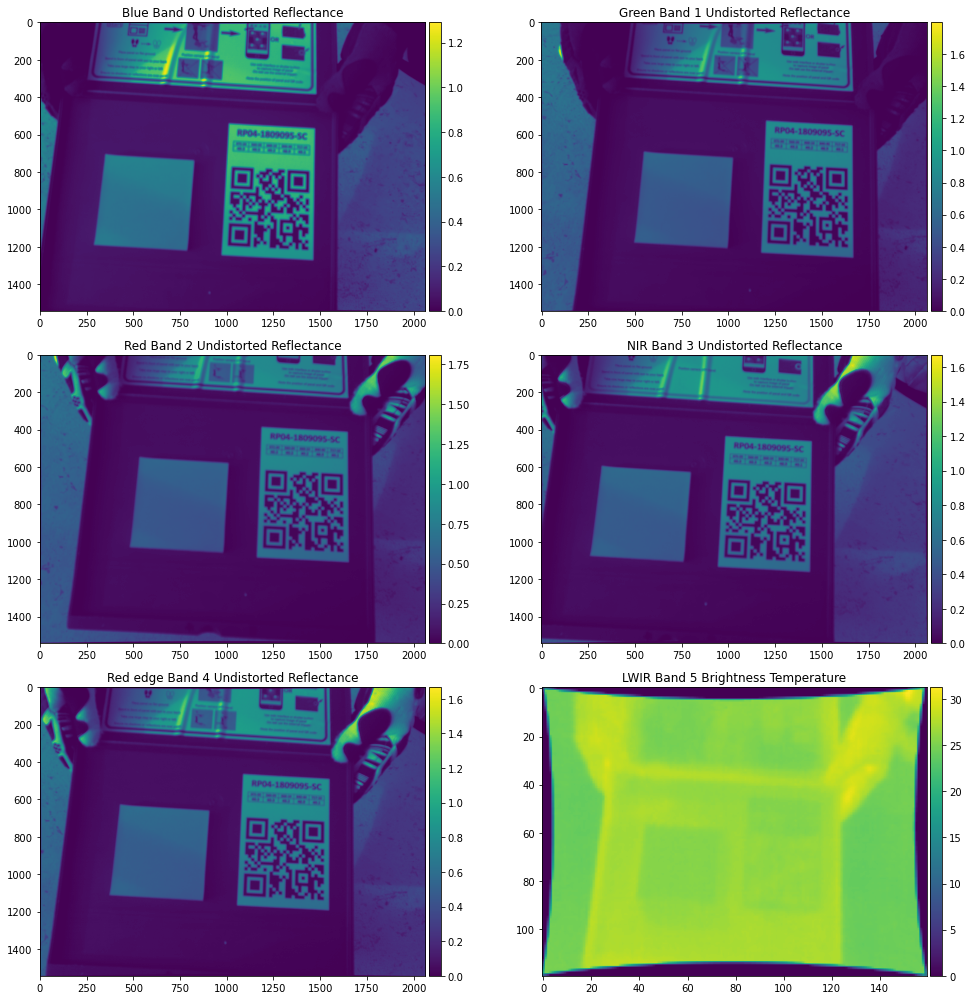

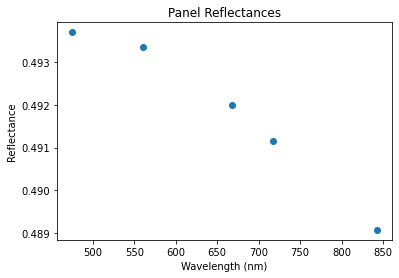

In [31]:
import math

panel_reflectance_by_band = [0.493, 0.493, 0.492, 0.489, 0.491] #RedEdge band_index order

panel_radiances = np.array(cap.panel_radiance())
irr_from_panel = math.pi * panel_radiances / panel_reflectance_by_band
dls_correction = irr_from_panel/cap.dls_irradiance()[:-1]
cap.plot_undistorted_reflectance(cap.dls_irradiance()[:-1]*dls_correction)

plt.scatter(cap.center_wavelengths()[:-1], cap.panel_reflectance())
plt.title("Panel Reflectances")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.show()

In [33]:
#TODO right now I'm manually putting the correction factor in and MAY WELL not be doing it right

In [35]:
warp_img_dir

'data/20210728_newport_neuse_surveys/flight3/sea/align_img'

In [39]:
# to use the DLS and not the panel set this to None
panelNames = None
#panelNames = glob.glob(os.path.join('data', '20210427_gulf_stream_surveys', 'flight3', 'panel', 'IMG_0014*.tif'))

surface_dir = os.path.join('data', '20210728_newport_neuse_surveys', 'flight1', 'sea')
warp_img_dir = os.path.join('data', '20210728_newport_neuse_surveys', 'flight1', 'sea', 'align_img')
surface_out = process_micasense_subset(surface_dir, panelNames, warp_img_dir, overwrite=False)

Not using panel irradiance.
used warp dir data/20210728_newport_neuse_surveys/flight1/sea/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 2
Finished aligning band 1
Finished aligning band 4
Finished aligning band 3
Saving time: 1:01:05.747367
Alignment+Saving rate: 0.21 images per second
Finished saving images.
exiftool -csv="data/20210728_newport_neuse_surveys/flight1/sea/stacks/log.csv" -overwrite_original data/20210728_newport_neuse_surveys/flight1/sea/stacks
Finished saving image metadata.


In [40]:
! exiftool -csv="data/20210728_newport_neuse_surveys/flight1/sea/stacks/log.csv" -overwrite_original data/20210728_newport_neuse_surveys/flight1/sea/stacks

    1 directories scanned
  752 image files updated


In [13]:
sky_dir = os.path.join('data', '20210427_gulf_stream_surveys', 'flight3', 'sky')
warp_img_dir = os.path.join('data', '20210427_gulf_stream_surveys', 'flight3', 'sky')
sky_out = process_micasense_subset(sky_dir, panelNames, warp_img_dir, overwrite=False)

Panel irradiance calculated.
used warp dir data/20210427_gulf_stream_surveys/flight3/sky
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 3
Finished aligning band 1
Finished aligning band 4
Finished aligning band 2
Saving time: 0:04:07.078883
Alignment+Saving rate: 0.32 images per second
Finished saving images.
exiftool -csv="data/20210427_gulf_stream_surveys/flight3/sky/stacks/log.csv" -overwrite_original data/20210427_gulf_stream_surveys/flight3/sky/stacks
Finished saving image metadata.


In [14]:
! exiftool -csv="data/20210427_gulf_stream_surveys/flight3/sky/stacks/log.csv" -overwrite_original data/20210427_gulf_stream_surveys/flight3/sky/stacks

    1 directories scanned
   80 image files updated


#### Now process the RedEdge Images

Need to ensure these are the correct images via time. They do seem correct.

Also note that the first couple sea images were bad because of spray and glint and shadow.

In [15]:
! ls data/20210427_gulf_stream_surveys/flight3/rededge/

panel  sea  sky  tube


In [48]:
# to use the DLS and not the panel set this to None
#panelNames = None
panelNames = glob.glob(os.path.join('data', '20210728_newport_neuse_surveys/flight1', 'rededge', 'panel', 'IMG_0003*.tif'))

blocked_dir = os.path.join('data', '20210728_newport_neuse_surveys/flight1', 'rededge', 'tube')
sky_dir = os.path.join('data', '20210728_newport_neuse_surveys/flight1', 'rededge', 'sky')
surface_dir = os.path.join('data', '20210728_newport_neuse_surveys/flight1', 'rededge', 'sea')

warp_img_dir = os.path.join('data', '20210728_newport_neuse_surveys/flight1', 'rededge', 'tube')
sunlight_blocked_out = process_micasense_subset(blocked_dir, panelNames, warp_img_dir, overwrite=False)

warp_img_dir = os.path.join('data', '20210728_newport_neuse_surveys/flight1', 'rededge', 'sky')
sky_out = process_micasense_subset(sky_dir, panelNames, warp_img_dir, overwrite=False)

warp_img_dir = os.path.join('data', '20210728_newport_neuse_surveys/flight1', 'rededge', 'sea')
surface_out = process_micasense_subset(surface_dir, panelNames, warp_img_dir, overwrite=False)

Panel irradiance calculated.
used warp dir data/20210728_newport_neuse_surveys/flight1/rededge/tube
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 2
Finished aligning band 3
Finished aligning band 4
Finished aligning band 1
Saving time: 0:00:18.045056
Alignment+Saving rate: 0.67 images per second
Finished saving images.
exiftool -csv="data/20210728_newport_neuse_surveys/flight1/rededge/tube/stacks/log.csv" -overwrite_original data/20210728_newport_neuse_surveys/flight1/rededge/tube/stacks
Finished saving image metadata.
Panel irradiance calculated.
used warp dir data/20210728_newport_neuse_surveys/flight1/rededge/sky
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 1
Finished aligning band 4
Finished aligning band 3
Finished aligning band 2
Saving time: 0:00:05.328013
Alignment+Saving rate: 0.94 images per second

In [49]:
! exiftool -csv="data/20210728_newport_neuse_surveys/flight1/rededge/tube/stacks/log.csv" -overwrite_original data/20210728_newport_neuse_surveys/flight1/rededge/tube/stacks

    1 directories scanned
   12 image files updated


In [50]:
! exiftool -csv="data/20210728_newport_neuse_surveys/flight1/rededge/sky/stacks/log.csv" -overwrite_original data/20210728_newport_neuse_surveys/flight1/rededge/sky/stacks


    1 directories scanned
    5 image files updated


In [51]:
! exiftool -csv="data/20210728_newport_neuse_surveys/flight1/rededge/sea/stacks/log.csv" -overwrite_original data/20210728_newport_neuse_surveys/flight1/rededge/sea/stacks


    1 directories scanned
    4 image files updated
